# CycleGAN, Image-to-Image Translation

In this notebook, we're going to define and train a CycleGAN to read in an image from a set $X$ and transform it so that it looks as if it belongs in set $Y$. Specifically, we'll look at a set of images of [Yosemite national park](https://en.wikipedia.org/wiki/Yosemite_National_Park) taken either during the summer of winter. The seasons are our two domains!

>The objective will be to train generators that learn to transform an image from domain $X$ into an image that looks like it came from domain $Y$ (and vice versa). 

Some examples of image data in both sets are pictured below.

<img src='notebook_images/XY_season_images.png' width=50% />

### Unpaired Training Data

These images do not come with labels, but CycleGANs give us a way to learn the mapping between one image domain and another using an **unsupervised** approach. A CycleGAN is designed for image-to-image translation and it learns from unpaired training data. This means that in order to train a generator to translate images from domain $X$ to domain $Y$, we do not have to have exact correspondences between individual images in those domains. For example, in [the paper that introduced CycleGANs](https://arxiv.org/abs/1703.10593), the authors are able to translate between images of horses and zebras, even though there are no images of a zebra in exactly the same position as a horse or with exactly the same background, etc. Thus, CycleGANs enable learning a mapping from one domain $X$ to another domain $Y$ without having to find perfectly-matched, training pairs!

<img src='notebook_images/horse2zebra.jpg' width=50% />

### CycleGAN and Notebook Structure

A CycleGAN is made of two types of networks: **discriminators, and generators**. In this example, the discriminators are responsible for classifying images as real or fake (for both $X$ and $Y$ kinds of images). The generators are responsible for generating convincing, fake images for both kinds of images. 

This notebook will detail the steps you should take to define and train such a CycleGAN. 

>1. You'll load in the image data using PyTorch's DataLoader class to efficiently read in images from a specified directory. 
2. Then, you'll be tasked with defining the CycleGAN architecture according to provided specifications. You'll define the discriminator and the generator models.
3. You'll complete the training cycle by calculating the adversarial and cycle consistency losses for the generator and discriminator network and completing a number of training epochs. *It's suggested that you enable GPU usage for training.*
4. Finally, you'll evaluate your model by looking at the loss over time and looking at sample, generated images.


In [1]:
import numpy as np

In [2]:
# import os as os
# edges = os.listdir('edges2phones/edges/edges')
# phones = os.listdir('edges2phones/phones/phones')
# print(len(edges))
# print(len(phones))
# edges = np.array(edges)
# phones = np.array(phones)

# rand = np.random.rand(1,7930)
# temp = rand<0.5
# print(temp.shape)
# edges = edges[temp.ravel()]
# print(edges.shape)

# rand = np.random.rand(1,7930)
# temp = rand<0.5
# print(temp.shape)
# phones = phones[temp.ravel()]
# print(phones.shape)
# edges = edges[rand[rand>=0.5]]
# print(edges.shape)

In [3]:
# phones = list(phones)
# print(len(phones))

# for phone in phones:
#     os.remove('edges2phones/phones/phones/'+phone)

    
# edges = list(edges)
# print(len(edges))
# for edges in edges:
#     os.remove('edges2phones/edges/edges/'+edges)


---

## Load and Visualize the Data

We'll first load in and visualize the training data, importing the necessary libraries to do so.

> If you are working locally, you'll need to download the data as a zip file by [clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

It may be named `summer2winter-yosemite` with a dash or an underscore, so take note and make sure the below `image_dir` accordingly. Then you can proceed with the following loading code.

In [4]:
# loading in and transforming data
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# visualizing data
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

### DataLoaders

The `get_data_loader` function returns training and test DataLoaders that can load data efficiently and in specified batches. The function has the following parameters:
* `image_type`: `summer` or `winter`,  the names of the directories where the X and Y images are stored
* `image_dir`: name of the main image directory, which holds all training and test images
* `image_size`: resized, square image dimension (all images will be resized to this dim)
* `batch_size`: number of images in one batch of data

The test data is strictly for feeding to our generators, later on, so we can visualize some generated samples on fixed, test data.

You can see that this function is also responsible for making sure our images are of the right, square size (128x128x3) and converted into Tensor image types.

**It's suggested that you use the default values of these parameters.**

Note: If you are trying this code on a different set of data, you may get better results with larger `image_size` and `batch_size` parameters. If you change the `batch_size`, make sure that you create complete batches in the training loop otherwise you may get an error when trying to save sample data. 

In [5]:
def get_data_loader(image_type, image_dir='summer2winter_yosemite', 
                    image_size=128, batch_size=16, num_workers=0):
    """Returns training and test data loaders for a given image type, either 'summer' or 'winter'. 
       These images will be resized to 128x128x3, by default, converted into Tensors, and normalized.
    """
    
    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize((208, 160)), # resize to 128x128
                                    transforms.ToTensor()])

    # get training and test directories
    image_path = './' + image_dir
    train_path = os.path.join(image_path, image_type)
    test_path = os.path.join(image_path, 'test_{}'.format(image_type))

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

In [6]:
# Create train and test dataloaders for images from the two domains X and Y
# image_type = directory names for our data
dataloader_X, test_dataloader_X = get_data_loader(image_dir='edges2phones', image_type='edges', batch_size=9)
dataloader_Y, test_dataloader_Y = get_data_loader(image_dir='edges2phones', image_type='phones', batch_size=9)

## Display some Training Images

Below we provide a function `imshow` that reshape some given images and converts them to NumPy images so that they can be displayed by `plt`. This cell should display a grid that contains a batch of image data from set $X$.

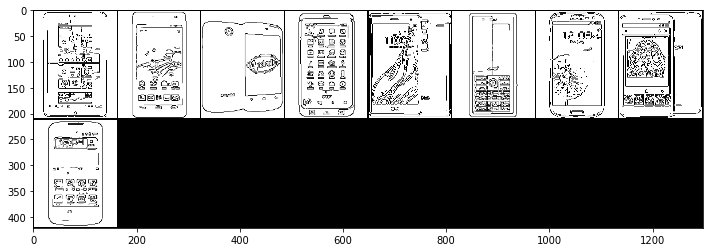

In [7]:
# helper imshow function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    

# get some images from X
dataiter = iter(dataloader_X)
# the "_" is a placeholder for no labels
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12, 8))
imshow(torchvision.utils.make_grid(images))

Next, let's visualize a batch of images from set $Y$.

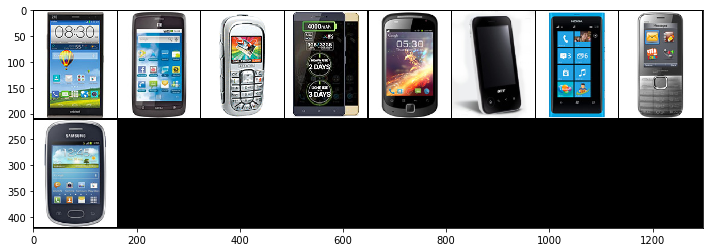

In [8]:
# get some images from Y
dataiter = iter(dataloader_Y)
images, _ = dataiter.next()

# show images
fig = plt.figure(figsize=(12,8))
imshow(torchvision.utils.make_grid(images))

### Pre-processing: scaling from -1 to 1

We need to do a bit of pre-processing; we know that the output of our `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [9]:
# current range
img = images[0]

print('Min: ', img.min())
print('Max: ', img.max())

Min:  tensor(0.)
Max:  tensor(1.)


In [10]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    
    # scale from 0-1 to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [11]:
# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())

Scaled min:  tensor(-1.)
Scaled max:  tensor(1.)


---
## Define the Model

A CycleGAN is made of two discriminator and two generator networks.

## Discriminators

The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='notebook_images/discriminator_layers.png' width=80% />

This network sees a 128x128x3 image, and passes it through 5 convolutional layers that downsample the image by a factor of 2. The first four convolutional layers have a BatchNorm and ReLu activation function applied to their output, and the last acts as a classification layer that outputs one value.

### Convolutional Helper Function

To define the discriminators, you're expected to use the provided `conv` function, which creates a convolutional layer + an optional batch norm layer.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### Define the Discriminator Architecture

Your task is to fill in the `__init__` function with the specified 5 layer conv net architecture. Both $D_X$ and $D_Y$ have the same architecture, so we only need to define one class, and later instantiate two discriminators. 
> It's recommended that you use a **kernel size of 4x4** and use that to determine the correct stride and padding size for each layer. [This Stanford resource](http://cs231n.github.io/convolutional-networks/#conv) may also help in determining stride and padding sizes.

* Define your convolutional layers in `__init__`
* Then fill in the forward behavior of the network

The `forward` function defines how an input image moves through the discriminator, and the most important thing is to pass it through your convolutional layers in order, with a **ReLu** activation function applied to all but the last layer.

You should **not** apply a sigmoid activation function to the output, here, and that is because we are planning on using a squared error loss for training. And you can read more about this loss function, later in the notebook.

In [13]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 4) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        # last, classification layer
        out = self.conv5(out)
        return out

## Generators

The generators, `G_XtoY` and `G_YtoX` (sometimes called F), are made of an **encoder**, a conv net that is responsible for turning an image into a smaller feature representation, and a **decoder**, a *transpose_conv* net that is responsible for turning that representation into an transformed image. These generators, one from XtoY and one from YtoX, have the following architecture:

<img src='notebook_images/cyclegan_generator_ex.png' width=90% />

This network sees a 128x128x3 image, compresses it into a feature representation as it goes through three convolutional layers and reaches a series of residual blocks. It goes through a few (typically 6 or more) of these residual blocks, then it goes through three transpose convolutional layers (sometimes called *de-conv* layers) which upsample the output of the resnet blocks and create a new image!

Note that most of the convolutional and transpose-convolutional layers have BatchNorm and ReLu functions applied to their outputs with the exception of the final transpose convolutional layer, which has a `tanh` activation function applied to the output. Also, the residual blocks are made of convolutional and batch normalization layers, which we'll go over in more detail, next.

---
### Residual Block Class

To define the generators, you're expected to define a `ResidualBlock` class which will help you connect the encoder and decoder portions of the generators. You might be wondering, what exactly is a Resnet block? It may sound familiar from something like ResNet50 for image classification, pictured below.

<img src='notebook_images/resnet_50.png' width=90%/>

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. You can read more about this proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the below image is from that paper.

<img src='notebook_images/resnet_block.png' width=40%/>

### Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

#### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


### Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [14]:
# residual block class
class ResidualBlock(nn.Module):
    """Defines a residual block.
       This adds an input x to a convolutional layer (applied to x) with the same size input and output.
       These blocks allow a model to learn an effective transformation from one domain to another.
    """
    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        # apply a ReLu activation the outputs of the first layer
        # return a summed output, x + resnet_block(x)
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return out_2
    

### Transpose Convolutional Helper Function

To define the generators, you're expected to use the above `conv` function, `ResidualBlock` class, and the below `deconv` helper function, which creates a transpose convolutional layer + an optional batchnorm layer.

In [15]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

---
## Define the Generator Architecture

* Complete the `__init__` function with the specified 3 layer **encoder** convolutional net, a series of residual blocks (the number of which is given by `n_res_blocks`), and then a 3 layer **decoder** transpose convolutional net.
* Then complete the `forward` function to define the forward behavior of the generators. Recall that the last layer has a `tanh` activation function.

Both $G_{XtoY}$ and $G_{YtoX}$ have the same architecture, so we only need to define one class, and later instantiate two generators.

In [16]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # 1. Define the encoder part of the generator
        
        # initial convolutional layer given, below
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 2. Define the resnet part of the generator
        # Residual blocks
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        # use sequential to create these layers
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Define the decoder part of the generator
        # two transpose convolutional layers and a third that looks a lot like the initial conv layer
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        # no batch norm on last layer
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)

    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        # tanh applied to last layer
        out = F.tanh(self.deconv3(out))

        return out

---
## Create the complete network

Using the classes you defined earlier, you can define the discriminators and generators necessary to create a complete CycleGAN. The given parameters should work for training.

First, create two discriminators, one for checking if $X$ sample images are real, and one for checking if $Y$ sample images are real. Then the generators. Instantiate two of them, one for transforming a painting into a realistic photo and one for transforming a photo into  into a painting.

In [17]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6):
    """Builds the generators and discriminators."""
    
    # Instantiate generators
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    # Instantiate discriminators
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # move models to GPU, if available
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        G_XtoY.to(device)
        G_YtoX.to(device)
        D_X.to(device)
        D_Y.to(device)
        print('Models moved to GPU.')
    else:
        print('Only CPU available.')

    return G_XtoY, G_YtoX, D_X, D_Y

In [18]:
# call the function to get models
G_XtoY, G_YtoX, D_X, D_Y = create_model()

D_X=torch.load('saved_model/D_X.pt')
G_XtoY=torch.load('saved_model/G_XtoY.pt')
D_Y=torch.load('saved_model/D_Y.pt')
G_YtoX=torch.load('saved_model/G_YtoX.pt')

Models moved to GPU.


## Check that you've implemented this correctly

The function `create_model` should return the two generator and two discriminator networks. After you've defined these discriminator and generator components, it's good practice to check your work. The easiest way to do this is to print out your model architecture and read through it to make sure the parameters are what you expected. The next cell will print out their architectures.

In [19]:
# helper function for printing the model architecture
def print_models(G_XtoY, G_YtoX, D_X, D_Y):
    """Prints model information for the generators and discriminators.
    """
    print("                     G_XtoY                    ")
    print("-----------------------------------------------")
    print(G_XtoY)
    print()

    print("                     G_YtoX                    ")
    print("-----------------------------------------------")
    print(G_YtoX)
    print()

    print("                      D_X                      ")
    print("-----------------------------------------------")
    print(D_X)
    print()

    print("                      D_Y                      ")
    print("-----------------------------------------------")
    print(D_Y)
    print()
    

# print all of the models
print_models(G_XtoY, G_YtoX, D_X, D_Y)

                     G_XtoY                    
-----------------------------------------------
CycleGenerator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv_layer1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

)

                      D_X                      
-----------------------------------------------
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

                      D_Y              

## Discriminator and Generator Losses

Computing the discriminator and the generator losses are key to getting a CycleGAN to train.

<img src='notebook_images/CycleGAN_loss.png' width=90% height=90% />

**Image from [original paper](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu et. al.**

* The CycleGAN contains two mapping functions $G: X \rightarrow Y$ and $F: Y \rightarrow X$, and associated adversarial discriminators $D_Y$ and $D_X$. **(a)** $D_Y$ encourages $G$ to translate $X$ into outputs indistinguishable from domain $Y$, and vice versa for $D_X$ and $F$.

* To further regularize the mappings, we introduce two cycle consistency losses that capture the intuition that if
we translate from one domain to the other and back again we should arrive at where we started. **(b)** Forward cycle-consistency loss and **(c)** backward cycle-consistency loss.

## Least Squares GANs

We've seen that regular GANs treat the discriminator as a classifier with the sigmoid cross entropy loss function. However, this loss function may lead to the vanishing gradients problem during the learning process. To overcome such a problem, we'll use a least squares loss function for the discriminator. This structure is also referred to as a least squares GAN or LSGAN, and you can [read the original paper on LSGANs, here](https://arxiv.org/pdf/1611.04076.pdf). The authors show that LSGANs are able to generate higher quality images than regular GANs and that this loss type is a bit more stable during training! 

### Discriminator Losses

The discriminator losses will be mean squared errors between the output of the discriminator, given an image, and the target value, 0 or 1, depending on whether it should classify that image as fake or real. For example, for a *real* image, `x`, we can train $D_X$ by looking at how close it is to recognizing and image `x` as real using the mean squared error:

```
out_x = D_X(x)
real_err = torch.mean((out_x-1)**2)
```

### Generator Losses

Calculating the generator losses will look somewhat similar to calculating the discriminator loss; there will still be steps in which you generate fake images that look like they belong to the set of $X$ images but are based on real images in set $Y$, and vice versa. You'll compute the "real loss" on those generated images by looking at the output of the discriminator as it's applied to these _fake_ images; this time, your generator aims to make the discriminator classify these fake images as *real* images. 

#### Cycle Consistency Loss

In addition to the adversarial losses, the generator loss terms will also include the **cycle consistency loss**. This loss is a measure of how good a reconstructed image is, when compared to an original image. 

Say you have a fake, generated image, `x_hat`, and a real image, `y`. You can get a reconstructed `y_hat` by applying `G_XtoY(x_hat) = y_hat` and then check to see if this reconstruction `y_hat` and the orginal image `y` match. For this, we recommed calculating the L1 loss, which is an absolute difference, between reconstructed and real images. You may also choose to multiply this loss by some weight value `lambda_weight` to convey its importance.

<img src='notebook_images/reconstruction_error.png' width=40% height=40% />

The total generator loss will be the sum of the generator losses and the forward and backward cycle consistency losses.

---
### Define Loss Functions

To help us calculate the discriminator and gnerator losses during training, let's define some helpful loss functions. Here, we'll define three.
1. `real_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as real. This should be a mean squared error.
2. `fake_mse_loss` that looks at the output of a discriminator and returns the error based on how close that output is to being classified as fake. This should be a mean squared error.
3. `cycle_consistency_loss` that looks at a set of real image and a set of reconstructed/generated images, and returns the mean absolute error between them. This has a `lambda_weight` parameter that will weight the mean absolute error in a batch.

It's recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get a starting value for `lambda_weight`.

In [20]:
def real_mse_loss(D_out):
    # how close is the produced output from being "real"?
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    # how close is the produced output from being "fake"?
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    # return weighted loss
    return lambda_weight*reconstr_loss    


### Define the Optimizers

Next, let's define how this model will update its weights. This, like the GANs you may have seen before, uses [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) optimizers for the discriminator and generator. It's again recommended that you take a [look at the original, CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to get starting hyperparameter values.


In [21]:
import torch.optim as optim

# hyperparams for Adam optimizer
lr=0.000001
beta1=0.5
beta2=0.999 # default value

g_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())  # Get generator parameters
# print(len(g_params))

# Create optimizers for the generators and discriminators
g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
d_x_optimizer = optim.Adam(D_X.parameters(), lr, [beta1, beta2])
d_y_optimizer = optim.Adam(D_Y.parameters(), lr, [beta1, beta2])

---

## Training a CycleGAN

When a CycleGAN trains, and sees one batch of real images from set $X$ and $Y$, it trains by performing the following steps:

**Training the Discriminators**
1. Compute the discriminator $D_X$ loss on real images
2. Generate fake images that look like domain $X$ based on real images in domain $Y$
3. Compute the fake loss for $D_X$
4. Compute the total loss and perform backpropagation and $D_X$ optimization
5. Repeat steps 1-4 only with $D_Y$ and your domains switched!


**Training the Generators**
1. Generate fake images that look like domain $X$ based on real images in domain $Y$
2. Compute the generator loss based on how $D_X$ responds to fake $X$
3. Generate *reconstructed* $\hat{Y}$ images based on the fake $X$ images generated in step 1
4. Compute the cycle consistency loss by comparing the reconstructions with real $Y$ images
5. Repeat steps 1-4 only swapping domains
6. Add up all the generator and reconstruction losses and perform backpropagation + optimization

<img src='notebook_images/cycle_consistency_ex.png' width=70% />


### Saving Your Progress

A CycleGAN repeats its training process, alternating between training the discriminators and the generators, for a specified number of training iterations. You've been given code that will save some example generated images that the CycleGAN has learned to generate after a certain number of training iterations. Along with looking at the losses, these example generations should give you an idea of how well your network has trained.

Below, you may choose to keep all default parameters; your only task is to calculate the appropriate losses and complete the training cycle.

In [22]:
def save_model():
    torch.save(G_XtoY, './G_XtoY.pt')
    torch.save(G_YtoX, './G_YtoX.pt')
    torch.save(D_X, './D_X.pt')
    torch.save(D_Y, './D_Y.pt')

In [23]:
# import save code
from helpers import save_samples,save_all_samples, checkpoint

In [24]:
# train the network

def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
#         print("Out x:", out_x.shape)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
#         print("fake_X", fake_X.shape)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
#         print("fake_Y", fake_Y.shape)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)

        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=9)
            G_YtoX.train()
            G_XtoY.train()
            save_model()

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)
    return losses


In [ ]:
def run():
    n_epochs = 10000 # keep this small when testing if a model first works
    losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)
run()

Epoch [   10/10000] | d_X_loss: 0.0747 | d_Y_loss: 0.2722 | g_total_loss: 4.7418
Epoch [   20/10000] | d_X_loss: 0.0569 | d_Y_loss: 0.3847 | g_total_loss: 4.9630
Epoch [   30/10000] | d_X_loss: 0.0787 | d_Y_loss: 0.3643 | g_total_loss: 4.7134
Epoch [   40/10000] | d_X_loss: 0.0590 | d_Y_loss: 0.3244 | g_total_loss: 4.4439
Epoch [   50/10000] | d_X_loss: 0.0382 | d_Y_loss: 0.3706 | g_total_loss: 4.6341
Epoch [   60/10000] | d_X_loss: 0.0413 | d_Y_loss: 0.3359 | g_total_loss: 4.7768
Epoch [   70/10000] | d_X_loss: 0.0807 | d_Y_loss: 0.2931 | g_total_loss: 4.8983
Epoch [   80/10000] | d_X_loss: 0.0361 | d_Y_loss: 0.2376 | g_total_loss: 5.1348
Epoch [   90/10000] | d_X_loss: 0.0576 | d_Y_loss: 0.3203 | g_total_loss: 4.6809
Epoch [  100/10000] | d_X_loss: 0.0635 | d_Y_loss: 0.3605 | g_total_loss: 4.8463


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000100-Y-X.png
Epoch [  110/10000] | d_X_loss: 0.0369 | d_Y_loss: 0.4032 | g_total_loss: 4.5480
Epoch [  120/10000] | d_X_loss: 0.0720 | d_Y_loss: 0.1935 | g_total_loss: 5.0679
Epoch [  130/10000] | d_X_loss: 0.0398 | d_Y_loss: 0.3837 | g_total_loss: 4.5176
Epoch [  140/10000] | d_X_loss: 0.0799 | d_Y_loss: 0.2296 | g_total_loss: 4.7958
Epoch [  150/10000] | d_X_loss: 0.0332 | d_Y_loss: 0.3619 | g_total_loss: 5.1093
Epoch [  160/10000] | d_X_loss: 0.0454 | d_Y_loss: 0.3414 | g_total_loss: 4.6076
Epoch [  170/10000] | d_X_loss: 0.0557 | d_Y_loss: 0.2354 | g_total_loss: 4.6860
Epoch [  180/10000] | d_X_loss: 0.0488 | d_Y_loss: 0.2486 | g_total_loss: 4.5532
Epoch [  190/10000] | d_X_loss: 0.0457 | d_Y_loss: 0.2668 | g_total_loss: 4.7174
Epoch [  200/10000] | d_X_loss: 0.0594 | d_Y_loss: 0.2655 | g_total_loss: 4.5505


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000200-Y-X.png
Epoch [  210/10000] | d_X_loss: 0.0587 | d_Y_loss: 0.3179 | g_total_loss: 4.7069
Epoch [  220/10000] | d_X_loss: 0.0554 | d_Y_loss: 0.2697 | g_total_loss: 4.8768
Epoch [  230/10000] | d_X_loss: 0.1036 | d_Y_loss: 0.3380 | g_total_loss: 4.6576
Epoch [  240/10000] | d_X_loss: 0.0489 | d_Y_loss: 0.3326 | g_total_loss: 4.7563
Epoch [  250/10000] | d_X_loss: 0.0606 | d_Y_loss: 0.2558 | g_total_loss: 4.6750
Epoch [  260/10000] | d_X_loss: 0.0567 | d_Y_loss: 0.3092 | g_total_loss: 4.5282
Epoch [  270/10000] | d_X_loss: 0.0735 | d_Y_loss: 0.2987 | g_total_loss: 4.3257
Epoch [  280/10000] | d_X_loss: 0.0357 | d_Y_loss: 0.3187 | g_total_loss: 4.8470
Epoch [  290/10000] | d_X_loss: 0.0899 | d_Y_loss: 0.3537 | g_total_loss: 4.4409
Epoch [  300/10000] | d_X_loss: 0.0388 | d_Y_loss: 0.1922 | g_total_loss: 4.4992


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000300-Y-X.png
Epoch [  310/10000] | d_X_loss: 0.0520 | d_Y_loss: 0.2664 | g_total_loss: 4.8532
Epoch [  320/10000] | d_X_loss: 0.0451 | d_Y_loss: 0.2861 | g_total_loss: 4.6417
Epoch [  330/10000] | d_X_loss: 0.0708 | d_Y_loss: 0.2942 | g_total_loss: 4.7592
Epoch [  340/10000] | d_X_loss: 0.0660 | d_Y_loss: 0.3068 | g_total_loss: 4.6696
Epoch [  350/10000] | d_X_loss: 0.0435 | d_Y_loss: 0.2584 | g_total_loss: 5.1254
Epoch [  360/10000] | d_X_loss: 0.0454 | d_Y_loss: 0.1951 | g_total_loss: 5.2070
Epoch [  370/10000] | d_X_loss: 0.0540 | d_Y_loss: 0.1988 | g_total_loss: 4.8849
Epoch [  380/10000] | d_X_loss: 0.0752 | d_Y_loss: 0.2615 | g_total_loss: 4.6084
Epoch [  390/10000] | d_X_loss: 0.1930 | d_Y_loss: 0.2613 | g_total_loss: 5.0277
Epoch [  400/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.2576 | g_total_loss: 4.7299


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000400-Y-X.png
Epoch [  410/10000] | d_X_loss: 0.0789 | d_Y_loss: 0.2403 | g_total_loss: 4.4170
Epoch [  420/10000] | d_X_loss: 0.0457 | d_Y_loss: 0.2430 | g_total_loss: 4.9447
Epoch [  430/10000] | d_X_loss: 0.0433 | d_Y_loss: 0.3266 | g_total_loss: 4.8077
Epoch [  440/10000] | d_X_loss: 0.0732 | d_Y_loss: 0.2620 | g_total_loss: 4.6591
Epoch [  450/10000] | d_X_loss: 0.0600 | d_Y_loss: 0.2009 | g_total_loss: 4.5518
Epoch [  460/10000] | d_X_loss: 0.0358 | d_Y_loss: 0.3087 | g_total_loss: 4.7785
Epoch [  470/10000] | d_X_loss: 0.0379 | d_Y_loss: 0.3615 | g_total_loss: 4.9583
Epoch [  480/10000] | d_X_loss: 0.0493 | d_Y_loss: 0.2345 | g_total_loss: 4.8231
Epoch [  490/10000] | d_X_loss: 0.0780 | d_Y_loss: 0.2543 | g_total_loss: 4.5888
Epoch [  500/10000] | d_X_loss: 0.0390 | d_Y_loss: 0.2523 | g_total_loss: 4.6722


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000500-Y-X.png
Epoch [  510/10000] | d_X_loss: 0.0666 | d_Y_loss: 0.3222 | g_total_loss: 5.2145
Epoch [  520/10000] | d_X_loss: 0.1003 | d_Y_loss: 0.3339 | g_total_loss: 4.7495
Epoch [  530/10000] | d_X_loss: 0.0664 | d_Y_loss: 0.3079 | g_total_loss: 4.5811
Epoch [  540/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.2989 | g_total_loss: 4.7147
Epoch [  550/10000] | d_X_loss: 0.0540 | d_Y_loss: 0.3184 | g_total_loss: 4.7811
Epoch [  560/10000] | d_X_loss: 0.0391 | d_Y_loss: 0.2408 | g_total_loss: 5.0884
Epoch [  570/10000] | d_X_loss: 0.0701 | d_Y_loss: 0.2387 | g_total_loss: 5.4122
Epoch [  580/10000] | d_X_loss: 0.0450 | d_Y_loss: 0.2595 | g_total_loss: 5.1285
Epoch [  590/10000] | d_X_loss: 0.0767 | d_Y_loss: 0.3321 | g_total_loss: 4.2187
Epoch [  600/10000] | d_X_loss: 0.0715 | d_Y_loss: 0.2599 | g_total_loss: 4.8055


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000600-Y-X.png
Epoch [  610/10000] | d_X_loss: 0.0602 | d_Y_loss: 0.3228 | g_total_loss: 4.7977
Epoch [  620/10000] | d_X_loss: 0.0417 | d_Y_loss: 0.2904 | g_total_loss: 5.1951
Epoch [  630/10000] | d_X_loss: 0.0815 | d_Y_loss: 0.2636 | g_total_loss: 4.5221
Epoch [  640/10000] | d_X_loss: 0.1025 | d_Y_loss: 0.2928 | g_total_loss: 4.4514
Epoch [  650/10000] | d_X_loss: 0.0633 | d_Y_loss: 0.2082 | g_total_loss: 4.9217
Epoch [  660/10000] | d_X_loss: 0.1131 | d_Y_loss: 0.2633 | g_total_loss: 5.1747
Epoch [  670/10000] | d_X_loss: 0.0703 | d_Y_loss: 0.2601 | g_total_loss: 4.5238
Epoch [  680/10000] | d_X_loss: 0.0667 | d_Y_loss: 0.2434 | g_total_loss: 4.8526
Epoch [  690/10000] | d_X_loss: 0.0652 | d_Y_loss: 0.2877 | g_total_loss: 4.7307
Epoch [  700/10000] | d_X_loss: 0.0401 | d_Y_loss: 0.2936 | g_total_loss: 4.6803


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000700-Y-X.png
Epoch [  710/10000] | d_X_loss: 0.0495 | d_Y_loss: 0.3133 | g_total_loss: 4.4868
Epoch [  720/10000] | d_X_loss: 0.0494 | d_Y_loss: 0.2834 | g_total_loss: 4.9505
Epoch [  730/10000] | d_X_loss: 0.0551 | d_Y_loss: 0.3827 | g_total_loss: 4.7958
Epoch [  740/10000] | d_X_loss: 0.0332 | d_Y_loss: 0.2700 | g_total_loss: 4.6011
Epoch [  750/10000] | d_X_loss: 0.0690 | d_Y_loss: 0.2828 | g_total_loss: 4.5837
Epoch [  760/10000] | d_X_loss: 0.0387 | d_Y_loss: 0.2481 | g_total_loss: 4.9372
Epoch [  770/10000] | d_X_loss: 0.0352 | d_Y_loss: 0.2532 | g_total_loss: 4.9867
Epoch [  780/10000] | d_X_loss: 0.0769 | d_Y_loss: 0.3362 | g_total_loss: 4.7757
Epoch [  790/10000] | d_X_loss: 0.0793 | d_Y_loss: 0.2166 | g_total_loss: 4.6332
Epoch [  800/10000] | d_X_loss: 0.0582 | d_Y_loss: 0.2869 | g_total_loss: 4.4526


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000800-Y-X.png
Epoch [  810/10000] | d_X_loss: 0.0788 | d_Y_loss: 0.3356 | g_total_loss: 4.6201
Epoch [  820/10000] | d_X_loss: 0.0466 | d_Y_loss: 0.3123 | g_total_loss: 5.1067
Epoch [  830/10000] | d_X_loss: 0.0506 | d_Y_loss: 0.2283 | g_total_loss: 4.8587
Epoch [  840/10000] | d_X_loss: 0.0818 | d_Y_loss: 0.3493 | g_total_loss: 4.8676
Epoch [  850/10000] | d_X_loss: 0.0556 | d_Y_loss: 0.3992 | g_total_loss: 4.6182
Epoch [  860/10000] | d_X_loss: 0.0408 | d_Y_loss: 0.3395 | g_total_loss: 5.1294
Epoch [  870/10000] | d_X_loss: 0.0466 | d_Y_loss: 0.3414 | g_total_loss: 4.5032
Epoch [  880/10000] | d_X_loss: 0.0646 | d_Y_loss: 0.2998 | g_total_loss: 4.7039
Epoch [  890/10000] | d_X_loss: 0.0499 | d_Y_loss: 0.2514 | g_total_loss: 4.7718
Epoch [  900/10000] | d_X_loss: 0.0393 | d_Y_loss: 0.2801 | g_total_loss: 4.5152


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-000900-Y-X.png
Epoch [  910/10000] | d_X_loss: 0.0415 | d_Y_loss: 0.2506 | g_total_loss: 4.8520
Epoch [  920/10000] | d_X_loss: 0.0661 | d_Y_loss: 0.3747 | g_total_loss: 4.2348
Epoch [  930/10000] | d_X_loss: 0.0655 | d_Y_loss: 0.3214 | g_total_loss: 4.8378
Epoch [  940/10000] | d_X_loss: 0.0647 | d_Y_loss: 0.2987 | g_total_loss: 4.3791
Epoch [  950/10000] | d_X_loss: 0.0595 | d_Y_loss: 0.2591 | g_total_loss: 5.1142
Epoch [  960/10000] | d_X_loss: 0.0668 | d_Y_loss: 0.2704 | g_total_loss: 4.7096
Epoch [  970/10000] | d_X_loss: 0.0570 | d_Y_loss: 0.3060 | g_total_loss: 4.8016
Epoch [  980/10000] | d_X_loss: 0.1079 | d_Y_loss: 0.2294 | g_total_loss: 4.2314
Epoch [  990/10000] | d_X_loss: 0.0416 | d_Y_loss: 0.4091 | g_total_loss: 4.8385
Epoch [ 1000/10000] | d_X_loss: 0.0459 | d_Y_loss: 0.2514 | g_total_loss: 4.3771


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001000-Y-X.png
Epoch [ 1010/10000] | d_X_loss: 0.0380 | d_Y_loss: 0.3951 | g_total_loss: 4.7180
Epoch [ 1020/10000] | d_X_loss: 0.0731 | d_Y_loss: 0.3042 | g_total_loss: 4.5557
Epoch [ 1030/10000] | d_X_loss: 0.0634 | d_Y_loss: 0.2728 | g_total_loss: 4.7338
Epoch [ 1040/10000] | d_X_loss: 0.0559 | d_Y_loss: 0.2633 | g_total_loss: 4.8618
Epoch [ 1050/10000] | d_X_loss: 0.0552 | d_Y_loss: 0.2170 | g_total_loss: 5.0239
Epoch [ 1060/10000] | d_X_loss: 0.0681 | d_Y_loss: 0.2112 | g_total_loss: 4.7747
Epoch [ 1070/10000] | d_X_loss: 0.0533 | d_Y_loss: 0.2529 | g_total_loss: 4.7112
Epoch [ 1080/10000] | d_X_loss: 0.0462 | d_Y_loss: 0.3029 | g_total_loss: 4.4493
Epoch [ 1090/10000] | d_X_loss: 0.0907 | d_Y_loss: 0.3079 | g_total_loss: 4.5798
Epoch [ 1100/10000] | d_X_loss: 0.0420 | d_Y_loss: 0.3955 | g_total_loss: 4.3647


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001100-Y-X.png
Epoch [ 1110/10000] | d_X_loss: 0.0840 | d_Y_loss: 0.2521 | g_total_loss: 4.6414
Epoch [ 1120/10000] | d_X_loss: 0.0369 | d_Y_loss: 0.4412 | g_total_loss: 4.6753
Epoch [ 1130/10000] | d_X_loss: 0.0664 | d_Y_loss: 0.3363 | g_total_loss: 4.8525
Epoch [ 1140/10000] | d_X_loss: 0.0709 | d_Y_loss: 0.3781 | g_total_loss: 4.4153
Epoch [ 1150/10000] | d_X_loss: 0.0384 | d_Y_loss: 0.3546 | g_total_loss: 4.7522
Epoch [ 1160/10000] | d_X_loss: 0.0399 | d_Y_loss: 0.3289 | g_total_loss: 4.8618
Epoch [ 1170/10000] | d_X_loss: 0.0508 | d_Y_loss: 0.3305 | g_total_loss: 4.6989
Epoch [ 1180/10000] | d_X_loss: 0.0572 | d_Y_loss: 0.3842 | g_total_loss: 4.5090
Epoch [ 1190/10000] | d_X_loss: 0.0480 | d_Y_loss: 0.3361 | g_total_loss: 4.8342
Epoch [ 1200/10000] | d_X_loss: 0.0522 | d_Y_loss: 0.3060 | g_total_loss: 4.5471


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001200-Y-X.png
Epoch [ 1210/10000] | d_X_loss: 0.0390 | d_Y_loss: 0.2629 | g_total_loss: 4.9131
Epoch [ 1220/10000] | d_X_loss: 0.0527 | d_Y_loss: 0.2259 | g_total_loss: 5.4826
Epoch [ 1230/10000] | d_X_loss: 0.0758 | d_Y_loss: 0.1542 | g_total_loss: 5.2871
Epoch [ 1240/10000] | d_X_loss: 0.0383 | d_Y_loss: 0.2694 | g_total_loss: 5.0576
Epoch [ 1250/10000] | d_X_loss: 0.0513 | d_Y_loss: 0.2683 | g_total_loss: 4.4749
Epoch [ 1260/10000] | d_X_loss: 0.0701 | d_Y_loss: 0.2890 | g_total_loss: 4.6389
Epoch [ 1270/10000] | d_X_loss: 0.0448 | d_Y_loss: 0.2942 | g_total_loss: 4.5490
Epoch [ 1280/10000] | d_X_loss: 0.0451 | d_Y_loss: 0.3163 | g_total_loss: 4.6745
Epoch [ 1290/10000] | d_X_loss: 0.1121 | d_Y_loss: 0.3136 | g_total_loss: 4.7433
Epoch [ 1300/10000] | d_X_loss: 0.1087 | d_Y_loss: 0.3621 | g_total_loss: 4.6089


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001300-Y-X.png
Epoch [ 1310/10000] | d_X_loss: 0.0527 | d_Y_loss: 0.3153 | g_total_loss: 4.5415
Epoch [ 1320/10000] | d_X_loss: 0.0421 | d_Y_loss: 0.2869 | g_total_loss: 4.8215
Epoch [ 1330/10000] | d_X_loss: 0.0437 | d_Y_loss: 0.2694 | g_total_loss: 4.8249
Epoch [ 1340/10000] | d_X_loss: 0.0662 | d_Y_loss: 0.3511 | g_total_loss: 4.8743
Epoch [ 1350/10000] | d_X_loss: 0.0539 | d_Y_loss: 0.2740 | g_total_loss: 4.7046
Epoch [ 1360/10000] | d_X_loss: 0.0469 | d_Y_loss: 0.2520 | g_total_loss: 4.6039
Epoch [ 1370/10000] | d_X_loss: 0.0833 | d_Y_loss: 0.2698 | g_total_loss: 4.3062
Epoch [ 1380/10000] | d_X_loss: 0.0705 | d_Y_loss: 0.3074 | g_total_loss: 4.8255
Epoch [ 1390/10000] | d_X_loss: 0.0728 | d_Y_loss: 0.2875 | g_total_loss: 4.9122
Epoch [ 1400/10000] | d_X_loss: 0.0462 | d_Y_loss: 0.2052 | g_total_loss: 4.7948


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001400-Y-X.png
Epoch [ 1410/10000] | d_X_loss: 0.1144 | d_Y_loss: 0.2736 | g_total_loss: 4.4423
Epoch [ 1420/10000] | d_X_loss: 0.0437 | d_Y_loss: 0.2910 | g_total_loss: 4.9321
Epoch [ 1430/10000] | d_X_loss: 0.0635 | d_Y_loss: 0.2459 | g_total_loss: 4.8485
Epoch [ 1440/10000] | d_X_loss: 0.0453 | d_Y_loss: 0.3071 | g_total_loss: 4.5309
Epoch [ 1450/10000] | d_X_loss: 0.0579 | d_Y_loss: 0.2875 | g_total_loss: 4.6605
Epoch [ 1460/10000] | d_X_loss: 0.0728 | d_Y_loss: 0.2822 | g_total_loss: 4.7779
Epoch [ 1470/10000] | d_X_loss: 0.0557 | d_Y_loss: 0.3214 | g_total_loss: 4.8578
Epoch [ 1480/10000] | d_X_loss: 0.0500 | d_Y_loss: 0.1935 | g_total_loss: 5.2492
Epoch [ 1490/10000] | d_X_loss: 0.0641 | d_Y_loss: 0.3249 | g_total_loss: 5.1078
Epoch [ 1500/10000] | d_X_loss: 0.0688 | d_Y_loss: 0.2408 | g_total_loss: 5.3278


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001500-Y-X.png
Epoch [ 1510/10000] | d_X_loss: 0.1058 | d_Y_loss: 0.2730 | g_total_loss: 4.7505
Epoch [ 1520/10000] | d_X_loss: 0.1033 | d_Y_loss: 0.3516 | g_total_loss: 4.7800
Epoch [ 1530/10000] | d_X_loss: 0.0374 | d_Y_loss: 0.2620 | g_total_loss: 4.8099
Epoch [ 1540/10000] | d_X_loss: 0.0700 | d_Y_loss: 0.3866 | g_total_loss: 4.7185
Epoch [ 1550/10000] | d_X_loss: 0.0460 | d_Y_loss: 0.3550 | g_total_loss: 4.5141
Epoch [ 1560/10000] | d_X_loss: 0.0546 | d_Y_loss: 0.2978 | g_total_loss: 4.5590
Epoch [ 1570/10000] | d_X_loss: 0.0707 | d_Y_loss: 0.2243 | g_total_loss: 5.1148
Epoch [ 1580/10000] | d_X_loss: 0.0398 | d_Y_loss: 0.2162 | g_total_loss: 5.2408
Epoch [ 1590/10000] | d_X_loss: 0.0669 | d_Y_loss: 0.2165 | g_total_loss: 4.8686
Epoch [ 1600/10000] | d_X_loss: 0.0473 | d_Y_loss: 0.3176 | g_total_loss: 4.9031


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001600-Y-X.png
Epoch [ 1610/10000] | d_X_loss: 0.0455 | d_Y_loss: 0.1709 | g_total_loss: 5.0526
Epoch [ 1620/10000] | d_X_loss: 0.0614 | d_Y_loss: 0.2735 | g_total_loss: 4.6273
Epoch [ 1630/10000] | d_X_loss: 0.0479 | d_Y_loss: 0.2404 | g_total_loss: 4.8248
Epoch [ 1640/10000] | d_X_loss: 0.0843 | d_Y_loss: 0.3817 | g_total_loss: 4.7313
Epoch [ 1650/10000] | d_X_loss: 0.0457 | d_Y_loss: 0.2508 | g_total_loss: 5.0434
Epoch [ 1660/10000] | d_X_loss: 0.0471 | d_Y_loss: 0.2611 | g_total_loss: 5.0078
Epoch [ 1670/10000] | d_X_loss: 0.0353 | d_Y_loss: 0.2861 | g_total_loss: 5.1775
Epoch [ 1680/10000] | d_X_loss: 0.0337 | d_Y_loss: 0.3544 | g_total_loss: 4.9066
Epoch [ 1690/10000] | d_X_loss: 0.0787 | d_Y_loss: 0.2711 | g_total_loss: 5.3746
Epoch [ 1700/10000] | d_X_loss: 0.0435 | d_Y_loss: 0.3973 | g_total_loss: 4.4127


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001700-Y-X.png
Epoch [ 1710/10000] | d_X_loss: 0.0371 | d_Y_loss: 0.2976 | g_total_loss: 5.0280
Epoch [ 1720/10000] | d_X_loss: 0.0454 | d_Y_loss: 0.2186 | g_total_loss: 4.7033
Epoch [ 1730/10000] | d_X_loss: 0.0586 | d_Y_loss: 0.2091 | g_total_loss: 4.8689
Epoch [ 1740/10000] | d_X_loss: 0.0382 | d_Y_loss: 0.3616 | g_total_loss: 4.9721
Epoch [ 1750/10000] | d_X_loss: 0.0362 | d_Y_loss: 0.2795 | g_total_loss: 4.8598
Epoch [ 1760/10000] | d_X_loss: 0.0326 | d_Y_loss: 0.1965 | g_total_loss: 4.8048
Epoch [ 1770/10000] | d_X_loss: 0.0418 | d_Y_loss: 0.2936 | g_total_loss: 4.9717
Epoch [ 1780/10000] | d_X_loss: 0.0624 | d_Y_loss: 0.3442 | g_total_loss: 5.0818
Epoch [ 1790/10000] | d_X_loss: 0.0444 | d_Y_loss: 0.3484 | g_total_loss: 4.5555
Epoch [ 1800/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.2960 | g_total_loss: 4.5295


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001800-Y-X.png
Epoch [ 1810/10000] | d_X_loss: 0.0457 | d_Y_loss: 0.2792 | g_total_loss: 4.6220
Epoch [ 1820/10000] | d_X_loss: 0.0439 | d_Y_loss: 0.3827 | g_total_loss: 4.3342
Epoch [ 1830/10000] | d_X_loss: 0.0439 | d_Y_loss: 0.2008 | g_total_loss: 5.0821
Epoch [ 1840/10000] | d_X_loss: 0.0883 | d_Y_loss: 0.3400 | g_total_loss: 4.6429
Epoch [ 1850/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.3365 | g_total_loss: 4.3820
Epoch [ 1860/10000] | d_X_loss: 0.0735 | d_Y_loss: 0.3212 | g_total_loss: 4.9027
Epoch [ 1870/10000] | d_X_loss: 0.0653 | d_Y_loss: 0.2424 | g_total_loss: 4.4895
Epoch [ 1880/10000] | d_X_loss: 0.0530 | d_Y_loss: 0.2833 | g_total_loss: 4.5677
Epoch [ 1890/10000] | d_X_loss: 0.0332 | d_Y_loss: 0.3203 | g_total_loss: 4.6628
Epoch [ 1900/10000] | d_X_loss: 0.0358 | d_Y_loss: 0.3330 | g_total_loss: 5.0884


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-001900-Y-X.png
Epoch [ 1910/10000] | d_X_loss: 0.0438 | d_Y_loss: 0.2599 | g_total_loss: 4.8089
Epoch [ 1920/10000] | d_X_loss: 0.0695 | d_Y_loss: 0.2805 | g_total_loss: 4.8680
Epoch [ 1930/10000] | d_X_loss: 0.0491 | d_Y_loss: 0.2106 | g_total_loss: 4.9076
Epoch [ 1940/10000] | d_X_loss: 0.0338 | d_Y_loss: 0.1833 | g_total_loss: 4.9038
Epoch [ 1950/10000] | d_X_loss: 0.0485 | d_Y_loss: 0.1848 | g_total_loss: 4.5863
Epoch [ 1960/10000] | d_X_loss: 0.1049 | d_Y_loss: 0.1829 | g_total_loss: 4.9477
Epoch [ 1970/10000] | d_X_loss: 0.0479 | d_Y_loss: 0.2468 | g_total_loss: 4.8440
Epoch [ 1980/10000] | d_X_loss: 0.0569 | d_Y_loss: 0.3014 | g_total_loss: 4.3149
Epoch [ 1990/10000] | d_X_loss: 0.0416 | d_Y_loss: 0.2845 | g_total_loss: 4.4647
Epoch [ 2000/10000] | d_X_loss: 0.0430 | d_Y_loss: 0.3733 | g_total_loss: 4.7576


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002000-Y-X.png
Epoch [ 2010/10000] | d_X_loss: 0.1078 | d_Y_loss: 0.3186 | g_total_loss: 5.0461
Epoch [ 2020/10000] | d_X_loss: 0.0645 | d_Y_loss: 0.3238 | g_total_loss: 4.6317
Epoch [ 2030/10000] | d_X_loss: 0.0365 | d_Y_loss: 0.2920 | g_total_loss: 4.7368
Epoch [ 2040/10000] | d_X_loss: 0.0430 | d_Y_loss: 0.3912 | g_total_loss: 5.2336
Epoch [ 2050/10000] | d_X_loss: 0.0323 | d_Y_loss: 0.2528 | g_total_loss: 4.8765
Epoch [ 2060/10000] | d_X_loss: 0.0680 | d_Y_loss: 0.3215 | g_total_loss: 4.5868
Epoch [ 2070/10000] | d_X_loss: 0.0440 | d_Y_loss: 0.3256 | g_total_loss: 4.5385
Epoch [ 2080/10000] | d_X_loss: 0.0461 | d_Y_loss: 0.2758 | g_total_loss: 4.7021
Epoch [ 2090/10000] | d_X_loss: 0.0681 | d_Y_loss: 0.3031 | g_total_loss: 4.3333
Epoch [ 2100/10000] | d_X_loss: 0.0761 | d_Y_loss: 0.3131 | g_total_loss: 4.7988


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002100-Y-X.png
Epoch [ 2110/10000] | d_X_loss: 0.0651 | d_Y_loss: 0.3110 | g_total_loss: 4.5916
Epoch [ 2120/10000] | d_X_loss: 0.0382 | d_Y_loss: 0.3471 | g_total_loss: 4.8110
Epoch [ 2130/10000] | d_X_loss: 0.0532 | d_Y_loss: 0.3237 | g_total_loss: 4.1039
Epoch [ 2140/10000] | d_X_loss: 0.0434 | d_Y_loss: 0.2343 | g_total_loss: 4.9924
Epoch [ 2150/10000] | d_X_loss: 0.0361 | d_Y_loss: 0.2136 | g_total_loss: 4.8344
Epoch [ 2160/10000] | d_X_loss: 0.0479 | d_Y_loss: 0.2238 | g_total_loss: 4.6430
Epoch [ 2170/10000] | d_X_loss: 0.0563 | d_Y_loss: 0.3121 | g_total_loss: 4.5815
Epoch [ 2180/10000] | d_X_loss: 0.0419 | d_Y_loss: 0.2743 | g_total_loss: 5.0824
Epoch [ 2190/10000] | d_X_loss: 0.0508 | d_Y_loss: 0.3349 | g_total_loss: 4.5825
Epoch [ 2200/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.3249 | g_total_loss: 4.5361


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002200-Y-X.png
Epoch [ 2210/10000] | d_X_loss: 0.0529 | d_Y_loss: 0.2827 | g_total_loss: 4.3522
Epoch [ 2220/10000] | d_X_loss: 0.0355 | d_Y_loss: 0.2709 | g_total_loss: 5.1309
Epoch [ 2230/10000] | d_X_loss: 0.0647 | d_Y_loss: 0.2000 | g_total_loss: 5.2716
Epoch [ 2240/10000] | d_X_loss: 0.0632 | d_Y_loss: 0.2393 | g_total_loss: 4.9329
Epoch [ 2250/10000] | d_X_loss: 0.0328 | d_Y_loss: 0.2831 | g_total_loss: 5.1111
Epoch [ 2260/10000] | d_X_loss: 0.0650 | d_Y_loss: 0.2778 | g_total_loss: 4.6199
Epoch [ 2270/10000] | d_X_loss: 0.0548 | d_Y_loss: 0.2820 | g_total_loss: 4.7377
Epoch [ 2280/10000] | d_X_loss: 0.0411 | d_Y_loss: 0.3854 | g_total_loss: 4.6868
Epoch [ 2290/10000] | d_X_loss: 0.0472 | d_Y_loss: 0.3069 | g_total_loss: 4.6364
Epoch [ 2300/10000] | d_X_loss: 0.0757 | d_Y_loss: 0.3375 | g_total_loss: 4.7390


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002300-Y-X.png
Epoch [ 2310/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.3364 | g_total_loss: 4.7206
Epoch [ 2320/10000] | d_X_loss: 0.0293 | d_Y_loss: 0.3016 | g_total_loss: 5.3159
Epoch [ 2330/10000] | d_X_loss: 0.0431 | d_Y_loss: 0.3378 | g_total_loss: 4.6726
Epoch [ 2340/10000] | d_X_loss: 0.0580 | d_Y_loss: 0.2993 | g_total_loss: 4.7229
Epoch [ 2350/10000] | d_X_loss: 0.0524 | d_Y_loss: 0.2791 | g_total_loss: 4.9072
Epoch [ 2360/10000] | d_X_loss: 0.0334 | d_Y_loss: 0.3168 | g_total_loss: 4.8278
Epoch [ 2370/10000] | d_X_loss: 0.0423 | d_Y_loss: 0.3078 | g_total_loss: 4.7609
Epoch [ 2380/10000] | d_X_loss: 0.0845 | d_Y_loss: 0.2328 | g_total_loss: 4.9869
Epoch [ 2390/10000] | d_X_loss: 0.0572 | d_Y_loss: 0.2706 | g_total_loss: 4.4049
Epoch [ 2400/10000] | d_X_loss: 0.0337 | d_Y_loss: 0.2842 | g_total_loss: 5.0046


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002400-Y-X.png
Epoch [ 2410/10000] | d_X_loss: 0.0416 | d_Y_loss: 0.3271 | g_total_loss: 5.3214
Epoch [ 2420/10000] | d_X_loss: 0.0306 | d_Y_loss: 0.2521 | g_total_loss: 4.9300
Epoch [ 2430/10000] | d_X_loss: 0.0340 | d_Y_loss: 0.3327 | g_total_loss: 4.5135
Epoch [ 2440/10000] | d_X_loss: 0.0440 | d_Y_loss: 0.3517 | g_total_loss: 5.0356
Epoch [ 2450/10000] | d_X_loss: 0.0479 | d_Y_loss: 0.2825 | g_total_loss: 4.6147
Epoch [ 2460/10000] | d_X_loss: 0.0329 | d_Y_loss: 0.1956 | g_total_loss: 4.7637
Epoch [ 2470/10000] | d_X_loss: 0.0290 | d_Y_loss: 0.2734 | g_total_loss: 4.6738
Epoch [ 2480/10000] | d_X_loss: 0.0392 | d_Y_loss: 0.3811 | g_total_loss: 4.4410
Epoch [ 2490/10000] | d_X_loss: 0.0399 | d_Y_loss: 0.3213 | g_total_loss: 4.7950
Epoch [ 2500/10000] | d_X_loss: 0.0540 | d_Y_loss: 0.3756 | g_total_loss: 4.6756


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002500-Y-X.png
Epoch [ 2510/10000] | d_X_loss: 0.0445 | d_Y_loss: 0.2835 | g_total_loss: 4.9658
Epoch [ 2520/10000] | d_X_loss: 0.0670 | d_Y_loss: 0.3695 | g_total_loss: 4.5910
Epoch [ 2530/10000] | d_X_loss: 0.0666 | d_Y_loss: 0.2763 | g_total_loss: 5.2157
Epoch [ 2540/10000] | d_X_loss: 0.0357 | d_Y_loss: 0.2358 | g_total_loss: 4.7479
Epoch [ 2550/10000] | d_X_loss: 0.0518 | d_Y_loss: 0.2408 | g_total_loss: 4.7404
Epoch [ 2560/10000] | d_X_loss: 0.0364 | d_Y_loss: 0.3044 | g_total_loss: 4.7804
Epoch [ 2570/10000] | d_X_loss: 0.0506 | d_Y_loss: 0.2656 | g_total_loss: 4.9689
Epoch [ 2580/10000] | d_X_loss: 0.0615 | d_Y_loss: 0.2836 | g_total_loss: 4.5399
Epoch [ 2590/10000] | d_X_loss: 0.0373 | d_Y_loss: 0.3076 | g_total_loss: 4.6836
Epoch [ 2600/10000] | d_X_loss: 0.0631 | d_Y_loss: 0.2440 | g_total_loss: 4.8260


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002600-Y-X.png
Epoch [ 2610/10000] | d_X_loss: 0.0407 | d_Y_loss: 0.2508 | g_total_loss: 4.8792
Epoch [ 2620/10000] | d_X_loss: 0.0288 | d_Y_loss: 0.3178 | g_total_loss: 5.3277
Epoch [ 2630/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.2993 | g_total_loss: 4.4372
Epoch [ 2640/10000] | d_X_loss: 0.0359 | d_Y_loss: 0.3071 | g_total_loss: 4.9814
Epoch [ 2650/10000] | d_X_loss: 0.0530 | d_Y_loss: 0.2587 | g_total_loss: 4.7862
Epoch [ 2660/10000] | d_X_loss: 0.0342 | d_Y_loss: 0.3472 | g_total_loss: 4.8554
Epoch [ 2670/10000] | d_X_loss: 0.0350 | d_Y_loss: 0.1799 | g_total_loss: 4.9072
Epoch [ 2680/10000] | d_X_loss: 0.0410 | d_Y_loss: 0.2682 | g_total_loss: 4.6290
Epoch [ 2690/10000] | d_X_loss: 0.0321 | d_Y_loss: 0.3038 | g_total_loss: 4.6758
Epoch [ 2700/10000] | d_X_loss: 0.0770 | d_Y_loss: 0.2650 | g_total_loss: 4.7425


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002700-Y-X.png
Epoch [ 2710/10000] | d_X_loss: 0.0387 | d_Y_loss: 0.2407 | g_total_loss: 4.8711
Epoch [ 2720/10000] | d_X_loss: 0.0287 | d_Y_loss: 0.3358 | g_total_loss: 4.7919
Epoch [ 2730/10000] | d_X_loss: 0.0542 | d_Y_loss: 0.2442 | g_total_loss: 4.6348
Epoch [ 2740/10000] | d_X_loss: 0.0538 | d_Y_loss: 0.3377 | g_total_loss: 4.4030
Epoch [ 2750/10000] | d_X_loss: 0.0385 | d_Y_loss: 0.2449 | g_total_loss: 5.1665
Epoch [ 2760/10000] | d_X_loss: 0.0372 | d_Y_loss: 0.2580 | g_total_loss: 5.0106
Epoch [ 2770/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.3223 | g_total_loss: 4.3902
Epoch [ 2780/10000] | d_X_loss: 0.0495 | d_Y_loss: 0.2488 | g_total_loss: 4.6931
Epoch [ 2790/10000] | d_X_loss: 0.0703 | d_Y_loss: 0.2090 | g_total_loss: 5.2369
Epoch [ 2800/10000] | d_X_loss: 0.0502 | d_Y_loss: 0.1664 | g_total_loss: 5.0384


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002800-Y-X.png
Epoch [ 2810/10000] | d_X_loss: 0.0368 | d_Y_loss: 0.2403 | g_total_loss: 4.5853
Epoch [ 2820/10000] | d_X_loss: 0.0377 | d_Y_loss: 0.2888 | g_total_loss: 4.7473
Epoch [ 2830/10000] | d_X_loss: 0.0286 | d_Y_loss: 0.2789 | g_total_loss: 4.7629
Epoch [ 2840/10000] | d_X_loss: 0.0591 | d_Y_loss: 0.1962 | g_total_loss: 4.5396
Epoch [ 2850/10000] | d_X_loss: 0.0306 | d_Y_loss: 0.3376 | g_total_loss: 4.4982
Epoch [ 2860/10000] | d_X_loss: 0.0528 | d_Y_loss: 0.2945 | g_total_loss: 4.7334
Epoch [ 2870/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.2674 | g_total_loss: 4.8867
Epoch [ 2880/10000] | d_X_loss: 0.0435 | d_Y_loss: 0.2794 | g_total_loss: 4.5582
Epoch [ 2890/10000] | d_X_loss: 0.0447 | d_Y_loss: 0.4086 | g_total_loss: 4.4933
Epoch [ 2900/10000] | d_X_loss: 0.1015 | d_Y_loss: 0.3644 | g_total_loss: 5.2887


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-002900-Y-X.png
Epoch [ 2910/10000] | d_X_loss: 0.0657 | d_Y_loss: 0.4128 | g_total_loss: 4.4648
Epoch [ 2920/10000] | d_X_loss: 0.0326 | d_Y_loss: 0.3058 | g_total_loss: 4.7975
Epoch [ 2930/10000] | d_X_loss: 0.0327 | d_Y_loss: 0.3136 | g_total_loss: 4.6615
Epoch [ 2940/10000] | d_X_loss: 0.0408 | d_Y_loss: 0.3187 | g_total_loss: 4.4046
Epoch [ 2950/10000] | d_X_loss: 0.0580 | d_Y_loss: 0.3859 | g_total_loss: 4.9399
Epoch [ 2960/10000] | d_X_loss: 0.0398 | d_Y_loss: 0.2874 | g_total_loss: 4.9835
Epoch [ 2970/10000] | d_X_loss: 0.0411 | d_Y_loss: 0.3420 | g_total_loss: 4.8494
Epoch [ 2980/10000] | d_X_loss: 0.0388 | d_Y_loss: 0.3206 | g_total_loss: 4.5658
Epoch [ 2990/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.2409 | g_total_loss: 4.8529
Epoch [ 3000/10000] | d_X_loss: 0.0605 | d_Y_loss: 0.2525 | g_total_loss: 4.4842


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003000-Y-X.png
Epoch [ 3010/10000] | d_X_loss: 0.1161 | d_Y_loss: 0.2853 | g_total_loss: 5.2294
Epoch [ 3020/10000] | d_X_loss: 0.0622 | d_Y_loss: 0.2001 | g_total_loss: 5.5515
Epoch [ 3030/10000] | d_X_loss: 0.0400 | d_Y_loss: 0.2331 | g_total_loss: 4.9087
Epoch [ 3040/10000] | d_X_loss: 0.0544 | d_Y_loss: 0.3972 | g_total_loss: 4.5396
Epoch [ 3050/10000] | d_X_loss: 0.0455 | d_Y_loss: 0.4060 | g_total_loss: 5.0623
Epoch [ 3060/10000] | d_X_loss: 0.0553 | d_Y_loss: 0.3183 | g_total_loss: 4.7798
Epoch [ 3070/10000] | d_X_loss: 0.0587 | d_Y_loss: 0.3865 | g_total_loss: 4.2090
Epoch [ 3080/10000] | d_X_loss: 0.0502 | d_Y_loss: 0.3249 | g_total_loss: 5.3374
Epoch [ 3090/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.3389 | g_total_loss: 4.4837
Epoch [ 3100/10000] | d_X_loss: 0.0315 | d_Y_loss: 0.2478 | g_total_loss: 4.8278


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003100-Y-X.png
Epoch [ 3110/10000] | d_X_loss: 0.0443 | d_Y_loss: 0.2279 | g_total_loss: 4.6153
Epoch [ 3120/10000] | d_X_loss: 0.0389 | d_Y_loss: 0.3671 | g_total_loss: 4.6225
Epoch [ 3130/10000] | d_X_loss: 0.0655 | d_Y_loss: 0.2682 | g_total_loss: 4.7976
Epoch [ 3140/10000] | d_X_loss: 0.0393 | d_Y_loss: 0.1788 | g_total_loss: 4.9937
Epoch [ 3150/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.3561 | g_total_loss: 4.9096
Epoch [ 3160/10000] | d_X_loss: 0.0545 | d_Y_loss: 0.3012 | g_total_loss: 4.8736
Epoch [ 3170/10000] | d_X_loss: 0.0459 | d_Y_loss: 0.2997 | g_total_loss: 4.7338
Epoch [ 3180/10000] | d_X_loss: 0.0768 | d_Y_loss: 0.3719 | g_total_loss: 4.2566
Epoch [ 3190/10000] | d_X_loss: 0.0618 | d_Y_loss: 0.3399 | g_total_loss: 4.9210
Epoch [ 3200/10000] | d_X_loss: 0.0383 | d_Y_loss: 0.2788 | g_total_loss: 4.7887


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003200-Y-X.png
Epoch [ 3210/10000] | d_X_loss: 0.0566 | d_Y_loss: 0.3100 | g_total_loss: 4.6675
Epoch [ 3220/10000] | d_X_loss: 0.0326 | d_Y_loss: 0.3396 | g_total_loss: 5.0270
Epoch [ 3230/10000] | d_X_loss: 0.0407 | d_Y_loss: 0.3497 | g_total_loss: 4.5969
Epoch [ 3240/10000] | d_X_loss: 0.0414 | d_Y_loss: 0.2323 | g_total_loss: 4.7742
Epoch [ 3250/10000] | d_X_loss: 0.0497 | d_Y_loss: 0.3251 | g_total_loss: 4.6345
Epoch [ 3260/10000] | d_X_loss: 0.0375 | d_Y_loss: 0.3352 | g_total_loss: 4.4899
Epoch [ 3270/10000] | d_X_loss: 0.0527 | d_Y_loss: 0.3085 | g_total_loss: 4.9512
Epoch [ 3280/10000] | d_X_loss: 0.0710 | d_Y_loss: 0.2792 | g_total_loss: 5.0216
Epoch [ 3290/10000] | d_X_loss: 0.0695 | d_Y_loss: 0.2755 | g_total_loss: 4.6223
Epoch [ 3300/10000] | d_X_loss: 0.0490 | d_Y_loss: 0.3198 | g_total_loss: 4.6412


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003300-Y-X.png
Epoch [ 3310/10000] | d_X_loss: 0.0513 | d_Y_loss: 0.2983 | g_total_loss: 4.7520
Epoch [ 3320/10000] | d_X_loss: 0.0391 | d_Y_loss: 0.4287 | g_total_loss: 4.5717
Epoch [ 3330/10000] | d_X_loss: 0.0778 | d_Y_loss: 0.1909 | g_total_loss: 4.4055
Epoch [ 3340/10000] | d_X_loss: 0.0430 | d_Y_loss: 0.2554 | g_total_loss: 4.8965
Epoch [ 3350/10000] | d_X_loss: 0.0437 | d_Y_loss: 0.2744 | g_total_loss: 4.7795
Epoch [ 3360/10000] | d_X_loss: 0.0531 | d_Y_loss: 0.2914 | g_total_loss: 4.9576
Epoch [ 3370/10000] | d_X_loss: 0.0471 | d_Y_loss: 0.3250 | g_total_loss: 4.6084
Epoch [ 3380/10000] | d_X_loss: 0.0335 | d_Y_loss: 0.3042 | g_total_loss: 4.9676
Epoch [ 3390/10000] | d_X_loss: 0.0401 | d_Y_loss: 0.2609 | g_total_loss: 4.5697
Epoch [ 3400/10000] | d_X_loss: 0.0797 | d_Y_loss: 0.2487 | g_total_loss: 4.3424


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003400-Y-X.png
Epoch [ 3410/10000] | d_X_loss: 0.0660 | d_Y_loss: 0.3594 | g_total_loss: 4.8600
Epoch [ 3420/10000] | d_X_loss: 0.0447 | d_Y_loss: 0.3629 | g_total_loss: 4.5143
Epoch [ 3430/10000] | d_X_loss: 0.0456 | d_Y_loss: 0.3185 | g_total_loss: 4.3754
Epoch [ 3440/10000] | d_X_loss: 0.0570 | d_Y_loss: 0.2485 | g_total_loss: 4.6653
Epoch [ 3450/10000] | d_X_loss: 0.1134 | d_Y_loss: 0.2992 | g_total_loss: 4.4416
Epoch [ 3460/10000] | d_X_loss: 0.0783 | d_Y_loss: 0.3213 | g_total_loss: 4.7310
Epoch [ 3470/10000] | d_X_loss: 0.0821 | d_Y_loss: 0.3487 | g_total_loss: 4.3342
Epoch [ 3480/10000] | d_X_loss: 0.0926 | d_Y_loss: 0.3045 | g_total_loss: 4.8532
Epoch [ 3490/10000] | d_X_loss: 0.0283 | d_Y_loss: 0.2710 | g_total_loss: 4.7528
Epoch [ 3500/10000] | d_X_loss: 0.1073 | d_Y_loss: 0.3121 | g_total_loss: 4.4340


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003500-Y-X.png
Epoch [ 3510/10000] | d_X_loss: 0.0694 | d_Y_loss: 0.2948 | g_total_loss: 4.5513
Epoch [ 3520/10000] | d_X_loss: 0.0535 | d_Y_loss: 0.3399 | g_total_loss: 4.6315
Epoch [ 3530/10000] | d_X_loss: 0.0395 | d_Y_loss: 0.2910 | g_total_loss: 4.5924
Epoch [ 3540/10000] | d_X_loss: 0.0379 | d_Y_loss: 0.3762 | g_total_loss: 4.5619
Epoch [ 3550/10000] | d_X_loss: 0.0700 | d_Y_loss: 0.2283 | g_total_loss: 4.8999
Epoch [ 3560/10000] | d_X_loss: 0.0411 | d_Y_loss: 0.2522 | g_total_loss: 4.9353
Epoch [ 3570/10000] | d_X_loss: 0.0310 | d_Y_loss: 0.2787 | g_total_loss: 4.9102
Epoch [ 3580/10000] | d_X_loss: 0.0473 | d_Y_loss: 0.4006 | g_total_loss: 4.8417
Epoch [ 3590/10000] | d_X_loss: 0.0354 | d_Y_loss: 0.2126 | g_total_loss: 4.5017
Epoch [ 3600/10000] | d_X_loss: 0.0432 | d_Y_loss: 0.1653 | g_total_loss: 4.8658


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003600-Y-X.png
Epoch [ 3610/10000] | d_X_loss: 0.0674 | d_Y_loss: 0.2864 | g_total_loss: 4.8946
Epoch [ 3620/10000] | d_X_loss: 0.0440 | d_Y_loss: 0.3336 | g_total_loss: 4.5013
Epoch [ 3630/10000] | d_X_loss: 0.0344 | d_Y_loss: 0.3591 | g_total_loss: 4.7276
Epoch [ 3640/10000] | d_X_loss: 0.0355 | d_Y_loss: 0.3858 | g_total_loss: 5.0426
Epoch [ 3650/10000] | d_X_loss: 0.0510 | d_Y_loss: 0.4035 | g_total_loss: 4.6982
Epoch [ 3660/10000] | d_X_loss: 0.0321 | d_Y_loss: 0.3969 | g_total_loss: 5.3054
Epoch [ 3670/10000] | d_X_loss: 0.0753 | d_Y_loss: 0.2490 | g_total_loss: 4.9693
Epoch [ 3680/10000] | d_X_loss: 0.0551 | d_Y_loss: 0.3224 | g_total_loss: 4.6070
Epoch [ 3690/10000] | d_X_loss: 0.0507 | d_Y_loss: 0.3412 | g_total_loss: 4.1832
Epoch [ 3700/10000] | d_X_loss: 0.0374 | d_Y_loss: 0.2281 | g_total_loss: 4.8339


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003700-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003700-Y-X.png
Epoch [ 3710/10000] | d_X_loss: 0.0530 | d_Y_loss: 0.3461 | g_total_loss: 4.6690
Epoch [ 3720/10000] | d_X_loss: 0.0390 | d_Y_loss: 0.3586 | g_total_loss: 4.5986
Epoch [ 3730/10000] | d_X_loss: 0.0327 | d_Y_loss: 0.3175 | g_total_loss: 5.0286
Epoch [ 3740/10000] | d_X_loss: 0.0496 | d_Y_loss: 0.3312 | g_total_loss: 4.5066
Epoch [ 3750/10000] | d_X_loss: 0.0432 | d_Y_loss: 0.3100 | g_total_loss: 4.4752
Epoch [ 3760/10000] | d_X_loss: 0.0369 | d_Y_loss: 0.2665 | g_total_loss: 4.9015
Epoch [ 3770/10000] | d_X_loss: 0.0379 | d_Y_loss: 0.2786 | g_total_loss: 4.7671
Epoch [ 3780/10000] | d_X_loss: 0.0440 | d_Y_loss: 0.4168 | g_total_loss: 4.7204
Epoch [ 3790/10000] | d_X_loss: 0.0355 | d_Y_loss: 0.3011 | g_total_loss: 4.8868
Epoch [ 3800/10000] | d_X_loss: 0.1657 | d_Y_loss: 0.2707 | g_total_loss: 4.5220


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003800-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003800-Y-X.png
Epoch [ 3810/10000] | d_X_loss: 0.0716 | d_Y_loss: 0.3429 | g_total_loss: 4.5148
Epoch [ 3820/10000] | d_X_loss: 0.0436 | d_Y_loss: 0.2469 | g_total_loss: 4.6614
Epoch [ 3830/10000] | d_X_loss: 0.0526 | d_Y_loss: 0.2615 | g_total_loss: 5.1153
Epoch [ 3840/10000] | d_X_loss: 0.0495 | d_Y_loss: 0.2752 | g_total_loss: 4.6615
Epoch [ 3850/10000] | d_X_loss: 0.0561 | d_Y_loss: 0.3341 | g_total_loss: 5.4480
Epoch [ 3860/10000] | d_X_loss: 0.0545 | d_Y_loss: 0.2920 | g_total_loss: 4.6485
Epoch [ 3870/10000] | d_X_loss: 0.0541 | d_Y_loss: 0.3950 | g_total_loss: 4.2087
Epoch [ 3880/10000] | d_X_loss: 0.0733 | d_Y_loss: 0.2963 | g_total_loss: 4.5510
Epoch [ 3890/10000] | d_X_loss: 0.0483 | d_Y_loss: 0.3810 | g_total_loss: 4.9077
Epoch [ 3900/10000] | d_X_loss: 0.0829 | d_Y_loss: 0.2811 | g_total_loss: 4.5127


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003900-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-003900-Y-X.png
Epoch [ 3910/10000] | d_X_loss: 0.0626 | d_Y_loss: 0.2820 | g_total_loss: 5.5279
Epoch [ 3920/10000] | d_X_loss: 0.0474 | d_Y_loss: 0.2350 | g_total_loss: 5.0242
Epoch [ 3930/10000] | d_X_loss: 0.0491 | d_Y_loss: 0.2080 | g_total_loss: 4.8062
Epoch [ 3940/10000] | d_X_loss: 0.2048 | d_Y_loss: 0.2507 | g_total_loss: 5.5643
Epoch [ 3950/10000] | d_X_loss: 0.0412 | d_Y_loss: 0.1997 | g_total_loss: 5.0233
Epoch [ 3960/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.2908 | g_total_loss: 4.7458
Epoch [ 3970/10000] | d_X_loss: 0.0508 | d_Y_loss: 0.3846 | g_total_loss: 4.5028
Epoch [ 3980/10000] | d_X_loss: 0.0552 | d_Y_loss: 0.2824 | g_total_loss: 4.7440
Epoch [ 3990/10000] | d_X_loss: 0.0923 | d_Y_loss: 0.1886 | g_total_loss: 5.4883
Epoch [ 4000/10000] | d_X_loss: 0.0425 | d_Y_loss: 0.3766 | g_total_loss: 4.5939


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004000-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004000-Y-X.png
Epoch [ 4010/10000] | d_X_loss: 0.0789 | d_Y_loss: 0.2886 | g_total_loss: 4.9033
Epoch [ 4020/10000] | d_X_loss: 0.0515 | d_Y_loss: 0.2857 | g_total_loss: 4.8509
Epoch [ 4030/10000] | d_X_loss: 0.1003 | d_Y_loss: 0.3481 | g_total_loss: 4.8937
Epoch [ 4040/10000] | d_X_loss: 0.0341 | d_Y_loss: 0.3278 | g_total_loss: 4.7102
Epoch [ 4050/10000] | d_X_loss: 0.0632 | d_Y_loss: 0.3087 | g_total_loss: 4.7919
Epoch [ 4060/10000] | d_X_loss: 0.0513 | d_Y_loss: 0.3074 | g_total_loss: 4.9247
Epoch [ 4070/10000] | d_X_loss: 0.0573 | d_Y_loss: 0.3734 | g_total_loss: 4.6672
Epoch [ 4080/10000] | d_X_loss: 0.0343 | d_Y_loss: 0.4040 | g_total_loss: 4.9141
Epoch [ 4090/10000] | d_X_loss: 0.0846 | d_Y_loss: 0.3804 | g_total_loss: 4.3227
Epoch [ 4100/10000] | d_X_loss: 0.0578 | d_Y_loss: 0.2250 | g_total_loss: 4.8605


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004100-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004100-Y-X.png
Epoch [ 4110/10000] | d_X_loss: 0.0737 | d_Y_loss: 0.4000 | g_total_loss: 4.5565
Epoch [ 4120/10000] | d_X_loss: 0.0382 | d_Y_loss: 0.3024 | g_total_loss: 4.6358
Epoch [ 4130/10000] | d_X_loss: 0.0312 | d_Y_loss: 0.3510 | g_total_loss: 4.8107
Epoch [ 4140/10000] | d_X_loss: 0.0383 | d_Y_loss: 0.2960 | g_total_loss: 4.8644
Epoch [ 4150/10000] | d_X_loss: 0.0359 | d_Y_loss: 0.3158 | g_total_loss: 4.7207
Epoch [ 4160/10000] | d_X_loss: 0.0769 | d_Y_loss: 0.1775 | g_total_loss: 5.1692
Epoch [ 4170/10000] | d_X_loss: 0.0385 | d_Y_loss: 0.3891 | g_total_loss: 4.6233
Epoch [ 4180/10000] | d_X_loss: 0.0370 | d_Y_loss: 0.2563 | g_total_loss: 4.7498
Epoch [ 4190/10000] | d_X_loss: 0.0381 | d_Y_loss: 0.3314 | g_total_loss: 4.7305
Epoch [ 4200/10000] | d_X_loss: 0.0500 | d_Y_loss: 0.3702 | g_total_loss: 4.8288


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004200-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004200-Y-X.png
Epoch [ 4210/10000] | d_X_loss: 0.0749 | d_Y_loss: 0.2576 | g_total_loss: 4.4406
Epoch [ 4220/10000] | d_X_loss: 0.0371 | d_Y_loss: 0.3171 | g_total_loss: 5.0049
Epoch [ 4230/10000] | d_X_loss: 0.0468 | d_Y_loss: 0.3308 | g_total_loss: 4.8214
Epoch [ 4240/10000] | d_X_loss: 0.0838 | d_Y_loss: 0.3357 | g_total_loss: 4.5349
Epoch [ 4250/10000] | d_X_loss: 0.0596 | d_Y_loss: 0.1944 | g_total_loss: 4.9921
Epoch [ 4260/10000] | d_X_loss: 0.0557 | d_Y_loss: 0.3436 | g_total_loss: 4.4275
Epoch [ 4270/10000] | d_X_loss: 0.0473 | d_Y_loss: 0.2749 | g_total_loss: 4.6566
Epoch [ 4280/10000] | d_X_loss: 0.0410 | d_Y_loss: 0.2433 | g_total_loss: 4.7044
Epoch [ 4290/10000] | d_X_loss: 0.0309 | d_Y_loss: 0.2716 | g_total_loss: 4.8869
Epoch [ 4300/10000] | d_X_loss: 0.0411 | d_Y_loss: 0.2741 | g_total_loss: 4.4269


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004300-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004300-Y-X.png
Epoch [ 4310/10000] | d_X_loss: 0.0429 | d_Y_loss: 0.3649 | g_total_loss: 4.5888
Epoch [ 4320/10000] | d_X_loss: 0.0507 | d_Y_loss: 0.3179 | g_total_loss: 4.8687
Epoch [ 4330/10000] | d_X_loss: 0.0655 | d_Y_loss: 0.3003 | g_total_loss: 4.4797
Epoch [ 4340/10000] | d_X_loss: 0.0441 | d_Y_loss: 0.2206 | g_total_loss: 4.5213
Epoch [ 4350/10000] | d_X_loss: 0.0504 | d_Y_loss: 0.3288 | g_total_loss: 4.7749
Epoch [ 4360/10000] | d_X_loss: 0.0906 | d_Y_loss: 0.3190 | g_total_loss: 4.8648
Epoch [ 4370/10000] | d_X_loss: 0.0545 | d_Y_loss: 0.2505 | g_total_loss: 5.1551
Epoch [ 4380/10000] | d_X_loss: 0.0450 | d_Y_loss: 0.2354 | g_total_loss: 5.0292
Epoch [ 4390/10000] | d_X_loss: 0.0654 | d_Y_loss: 0.2960 | g_total_loss: 4.5033
Epoch [ 4400/10000] | d_X_loss: 0.0698 | d_Y_loss: 0.3300 | g_total_loss: 4.6626


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004400-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004400-Y-X.png
Epoch [ 4410/10000] | d_X_loss: 0.0623 | d_Y_loss: 0.3924 | g_total_loss: 4.2714
Epoch [ 4420/10000] | d_X_loss: 0.0517 | d_Y_loss: 0.3168 | g_total_loss: 4.7738
Epoch [ 4430/10000] | d_X_loss: 0.0466 | d_Y_loss: 0.2571 | g_total_loss: 4.7976
Epoch [ 4440/10000] | d_X_loss: 0.0611 | d_Y_loss: 0.2880 | g_total_loss: 4.2504
Epoch [ 4450/10000] | d_X_loss: 0.0481 | d_Y_loss: 0.2740 | g_total_loss: 4.3356
Epoch [ 4460/10000] | d_X_loss: 0.0647 | d_Y_loss: 0.2628 | g_total_loss: 5.0681
Epoch [ 4470/10000] | d_X_loss: 0.0399 | d_Y_loss: 0.3048 | g_total_loss: 4.7661
Epoch [ 4480/10000] | d_X_loss: 0.0511 | d_Y_loss: 0.3512 | g_total_loss: 4.9015
Epoch [ 4490/10000] | d_X_loss: 0.0766 | d_Y_loss: 0.4299 | g_total_loss: 4.3663
Epoch [ 4500/10000] | d_X_loss: 0.0918 | d_Y_loss: 0.2651 | g_total_loss: 4.4263


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004500-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004500-Y-X.png
Epoch [ 4510/10000] | d_X_loss: 0.0414 | d_Y_loss: 0.2885 | g_total_loss: 4.6433
Epoch [ 4520/10000] | d_X_loss: 0.0358 | d_Y_loss: 0.3374 | g_total_loss: 4.6813
Epoch [ 4530/10000] | d_X_loss: 0.0649 | d_Y_loss: 0.3389 | g_total_loss: 4.7962
Epoch [ 4540/10000] | d_X_loss: 0.0733 | d_Y_loss: 0.3436 | g_total_loss: 4.6061
Epoch [ 4550/10000] | d_X_loss: 0.1101 | d_Y_loss: 0.3919 | g_total_loss: 4.6120
Epoch [ 4560/10000] | d_X_loss: 0.0434 | d_Y_loss: 0.2479 | g_total_loss: 4.8439
Epoch [ 4570/10000] | d_X_loss: 0.0777 | d_Y_loss: 0.3081 | g_total_loss: 4.6333
Epoch [ 4580/10000] | d_X_loss: 0.0548 | d_Y_loss: 0.2765 | g_total_loss: 4.9744
Epoch [ 4590/10000] | d_X_loss: 0.0783 | d_Y_loss: 0.3558 | g_total_loss: 4.6774
Epoch [ 4600/10000] | d_X_loss: 0.0404 | d_Y_loss: 0.3070 | g_total_loss: 5.1401


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004600-X-Y.png


Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


Saved samples_cyclegan\sample-004600-Y-X.png


## Tips on Training and Loss Patterns

A lot of experimentation goes into finding the best hyperparameters such that the generators and discriminators don't overpower each other. It's often a good starting point to look at existing papers to find what has worked in previous experiments, I'd recommend this [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) in addition to the original [CycleGAN paper](https://arxiv.org/pdf/1703.10593.pdf) to see what worked for them. Then, you can try your own experiments based off of a good foundation.

#### Discriminator Losses

When you display the generator and discriminator losses you should see that there is always some discriminator loss; recall that we are trying to design a model that can generate good "fake" images. So, the ideal discriminator will not be able to tell the difference between real and fake images and, as such, will always have some loss. You should also see that $D_X$ and $D_Y$ are roughly at the same loss levels; if they are not, this indicates that your training is favoring one type of discriminator over the and you may need to look at biases in your models or data.

#### Generator Loss

The generator's loss should start significantly higher than the discriminator losses because it is accounting for the loss of both generators *and* weighted reconstruction errors. You should see this loss decrease a lot at the start of training because initial, generated images are often far-off from being good fakes. After some time it may level off; this is normal since the generator and discriminator are both improving as they train. If you see that the loss is jumping around a lot, over time, you may want to try decreasing your learning rates or changing your cycle consistency loss to be a little more/less weighted.


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

---
## Evaluate the Result!

As you trained this model, you may have chosen to sample and save the results of your generated images after a certain number of training iterations. This gives you a way to see whether or not your Generators are creating *good* fake images. For example, the image below depicts real images in the $Y$ set, and the corresponding generated images during different points in the training process. You can see that the generator starts out creating very noisy, fake images, but begins to converge to better representations as it trains (though, not perfect).

<img src='notebook_images/sample-004000-summer2winter.png' width=50% />

Below, you've been given a helper function for displaying generated samples based on the passed in training iteration.

In [ ]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')


In [ ]:
# view samples at iteration 100
view_samples(23, 'samples_cyclegan')

In [ ]:
# view samples at iteration 4000
view_samples(4000, 'samples_cyclegan')

# Generate Images

In [ ]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    print_every=10
    
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)
    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]
    fixed_X = scale(fixed_X) # make sure to scale to a range -1 to 1
    fixed_Y = scale(fixed_Y)

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, 2):

        # Reset iterators for each epoch
        #if epoch % batches_per_epoch == 0:
            
             

        images_X, _ = iter_X.next()
        images_X = scale(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = scale(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
#         print("Out x:", out_x.shape)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)
#         print("fake_X", fake_X.shape)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss


        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)
#         print("fake_Y", fake_Y.shape)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss



        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ##    First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)


        ##    Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)

        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss



        # Print the log info
        if epoch % batches_per_epoch+1 == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            
        G_YtoX.eval() # set generators to eval mode for sample generation
        G_XtoY.eval()
        save_all_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=9)
        G_YtoX.train()
        G_XtoY.train()
        
        # Save the generated samples
        
        

        # uncomment these lines, if you want to save your model
#         checkpoint_every=1000
#         # Save the model parameters
#         if epoch % checkpoint_every == 0:
#             checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)
    return losses


In [ ]:
n_epochs = 1 # keep this small when testing if a model first works

losses = training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, n_epochs=n_epochs)

---
## Further Challenges and Directions

* One shortcoming of this model is that it produces fairly low-resolution images; this is an ongoing area of research; you can read about a higher-resolution formulation that uses a multi-scale generator model, in [this paper](https://arxiv.org/abs/1711.11585).
* Relatedly, we may want to process these as larger (say 256x256) images at first, to take advantage of high-res data.
* It may help your model to converge faster, if you initialize the weights in your network.
* This model struggles with matching colors exactly. This is because, if $G_{YtoX}$ and $G_{XtoY}$ may change the tint of an image; the cycle consistency loss may not be affected and can still be small. You could choose to introduce a new, color-based loss term that compares $G_{YtoX}(y)$ and $y$, and $G_{XtoY}(x)$ and $x$, but then this becomes a supervised learning approach. 
* This unsupervised approach also struggles with geometric changes, like changing the apparent size of individual object in an image, so it is best suited for stylistic transformations.
* For creating different kinds of models or trying out the Pix2Pix Architecture, [this Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/) which implements CycleGAN *and* Pix2Pix in PyTorch is a great resource.

**Once you are satified with your model, you are ancouraged to test it on a different dataset to see if it can find different types of mappings!**

---

### Different datasets for download

You can download a variety of datasets used in the Pix2Pix and CycleGAN papers, by following instructions in the [associated Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/README.md). You'll just need to make sure that the data directories are named and organized correctly to load in that data.